Bibliotheken

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np


from model_ARIMA import build_ARIMA_model, grid_search, grid_search_and_build_model
from model_naiv import build_naive_model
from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import residual_plot, acf_resid_plot, box_pierce_test, ljung_box_test, durbin_watson_test, breusch_godfrey_test
from test_variance import goldfeldquandt_test, breuschpagan_test, koenkerbasset_test
from test_normal import hist_plot, kolmogorov_test
from time_series import seasonal_plot, seasonal_subseries_plot, acf_plot, lag_plot, decompose, arima_residuals_for_all_stores, naive_residuals_for_all_stores
from dataset import clean, features, scatter_plot, boxplot


warnings.filterwarnings("ignore")

Datensatz lesen

In [2]:
try:
    df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)

except FileNotFoundError:
    print("Error: File not found. Please check the file path.")

except Exception as e:
    print("An error occurred while loading the dataset:", e)


df.columns = df.columns.str.lower()

Datensatz aufräumen

In [3]:
clean(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         6435 non-null   int64         
 1   date          6435 non-null   datetime64[ns]
 2   weekly_sales  6435 non-null   float64       
 3   holiday_flag  6435 non-null   int64         
 4   temperature   6435 non-null   float64       
 5   fuel_price    6435 non-null   float64       
 6   cpi           6435 non-null   float64       
 7   unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB
All values in 'date' column are valid dates.
The data contains 0 duplicate values


Datensatz untersuchen

In [4]:
print(f'Der Datensatz enthält {df.shape[0]} Reihen und {df.shape[1]} Spalten')
df.describe()

Der Datensatz enthält 6435 Reihen und 8 Spalten


,store,date,weekly_sales,holiday_flag,temperature,fuel_price,cpi,unemployment
count,6435.000000,6435,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,2011-06-17 00:00:00,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
min,1.000000,2010-02-05 00:00:00,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,2010-10-08 00:00:00,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,2011-06-17 00:00:00,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,2012-02-24 00:00:00,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,2012-10-26 00:00:00,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000
std,12.988182,NaN,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885


In [ ]:
features(df)
scatter_plot(df)
boxplot(df)

Auswählen

In [6]:
# Filtern nach Store
store_number = 2
store = df[df['store'] == store_number].copy()

# Datensatz nach Datum sortieren und als Index setzen
store.sort_values('date', inplace=True)
store.set_index('date', inplace=True)

# Nur die Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Weekly Sales für Store 1')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

Seasonal

In [ ]:
seasonal_plot(sales)
seasonal_subseries_plot(sales)
acf_plot(sales)
lag_plot(sales)
decompose(sales)

ARIMA Modell

In [9]:
arima_model = grid_search_and_build_model(sales)
arima_fitted = arima_model.fittedvalues
arima_resid = sales - arima_fitted


Bestes Modell: ARIMA(2, 0, 2) mit AIC: 3913.45


Naives Modell

In [10]:
naiv_resid, naiv_fitted = build_naive_model(sales)

Aussuchen

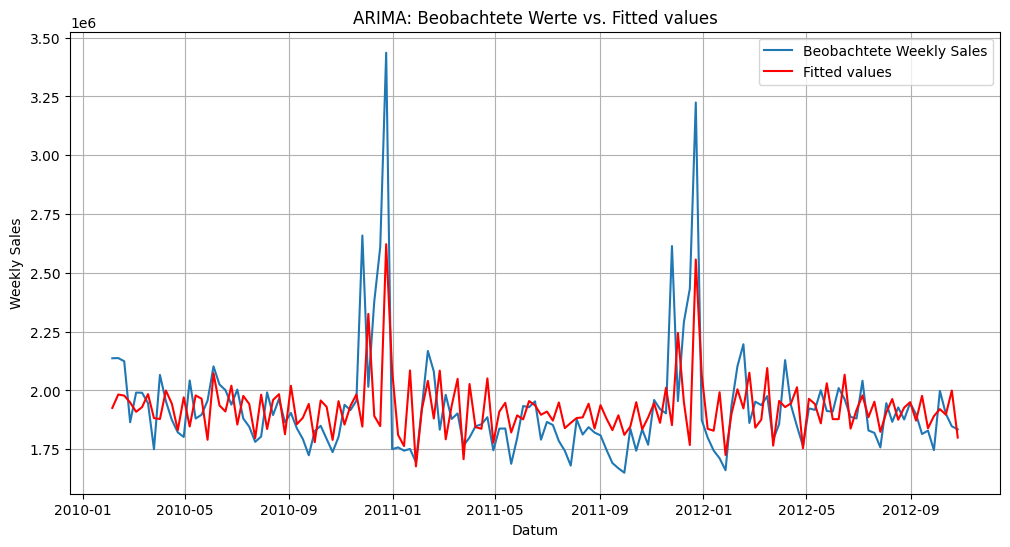

In [11]:
#residuen = naiv_resid
#fitted_values = naiv_fitted
residuen = arima_resid
fitted_values = arima_fitted


plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachtete Weekly Sales')
plt.plot(fitted_values, color='red', label='Fitted values')
plt.title('ARIMA: Beobachtete Werte vs. Fitted values')
plt.xlabel('Datum')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

Tests

Mittelwert der Residuen: 600.4085


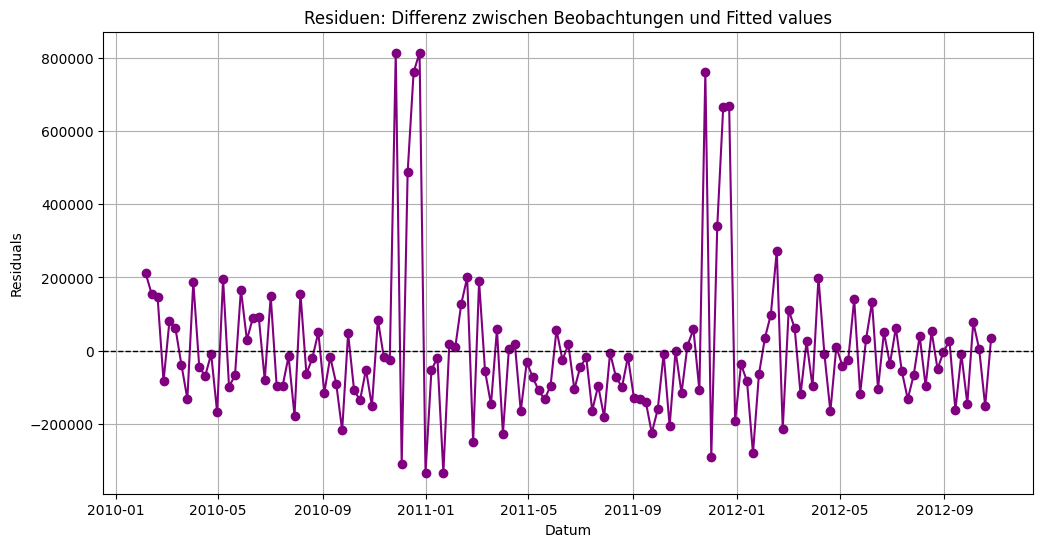

<Figure size 1200x600 with 0 Axes>

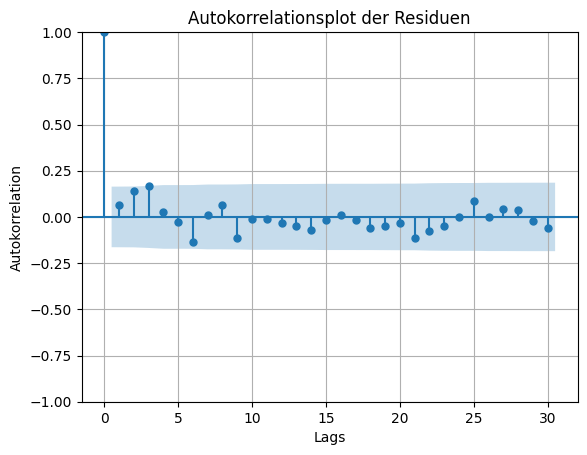

Box Pierce: 0.2389


In [12]:
mean_resid = residuen.mean()
print(f"Mittelwert der Residuen: {mean_resid:.4f}")
residual_plot(residuen)
acf_resid_plot(residuen)
bp_stat, bp_pvalue = box_pierce_test(residuen)
print(f"Box Pierce: {bp_pvalue:.4f}")

Alle ARIMA Residuen berechnen

In [3]:
#residuals_dict = arima_residuals_for_all_stores('Walmart_Sales.csv')
residuals_dict = naive_residuals_for_all_stores('Walmart_Sales.csv')

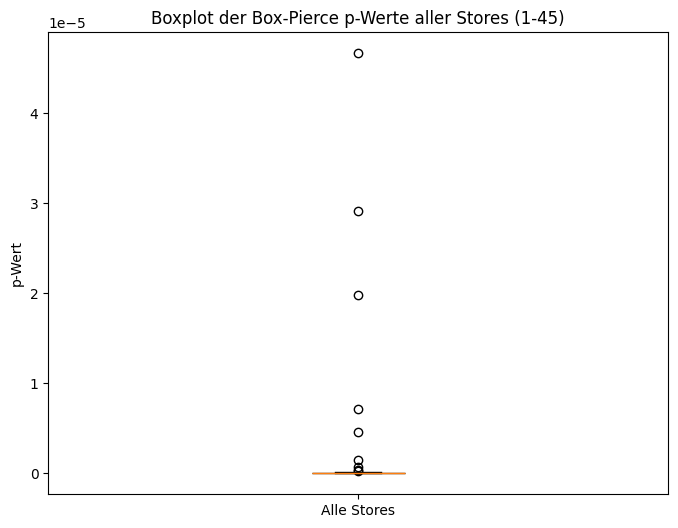

In [ ]:
bp_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            _, p_value = box_pierce_test(resid, lags=[10])
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(bp_pvalues, patch_artist=True)
plt.title("Boxplot der Box-Pierce p-Werte aller Stores (1-45)")
plt.ylabel("p-Wert")
plt.xticks([1], ["Alle Stores"])
plt.show()

print(bp_pvalues)